In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import tensorflow

d:\machine learning\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST_data')
# separate train and test data
train_data = data.train.images
train_label = data.train.labels

test_data = data.test.images
test_label = data.test.labels


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
img_len  = train_data.shape[1]
img_size = np.int(np.sqrt(img_len))
print(img_len)
print(img_size)

784
28


In [4]:
print('train_data shape',train_data.shape)
print('train label length',train_label.shape)
print('test data shape',test_data.shape)
print('test label length',test_label.shape)

train_data shape (55000, 784)
train label length (55000,)
test data shape (10000, 784)
test label length (10000,)


## Parameter Initialization 

In [5]:
# GRADED FUNCTION: initialize_parameters_deep

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## Helper function

In [6]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [7]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [8]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [9]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [10]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    #p = np.zeros((1,m))
    predicted_class = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    predicted_class = np.argmax(probas,axis=0).reshape(1,-1)
    true_class = np.argmax(y,axis=0).reshape(1,-1)
    acc = np.mean(predicted_class == true_class)
    #print ( 'training accuracy: %.2f' % (np.mean(predicted_class == true_class)) )
    '''
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    '''    
    return predicted_class,acc

In [11]:
def convt_oneHotcoded(labels,no_class):
    from scipy.sparse import csr_matrix
    import numpy as np
    data_len = labels.shape[1]
    indptr = np.arange(0,data_len+1)
    indices = labels.reshape(-1)
    data = np.ones(data_len)

    output_mat =  csr_matrix((data, indices, indptr), shape=(data_len,no_class)).toarray() 
    output_mat = output_mat.T
    # shape=(data_len, 10),  here we know out put labels ranges from 0 to 10
    return output_mat


In [12]:
def next_batch_x(data, labels, num):
    '''
    Return a total of `num` random samples and labels. 
    '''
    no_example = data.shape[1]
    idx = np.arange(0 , no_example)
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[:,idx]
    labels_shuffle = labels[:,idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [13]:
def createTrainTest (data,label):
  #  train_data = []
  #  train_label = []
  #  test_data = []
  #  test_label = []
    
    import numpy as np
    np.random.seed(3)
    idx = np.arange(data.shape[1])
    np.random.shuffle(idx)

    train_data = data[:,0:np.int(len(idx)*0.8)]
    train_label = label[:,0:np.int(len(idx)*0.8)]

    test_data =  data[:,np.int(len(idx)*0.8):]
    test_label =  label[:,np.int(len(idx)*0.8):]

    #train_label = np.squeeze (train_label)
    return train_data,train_label,test_data,test_label

## Forward propagation module
$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{1}$$
$$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})\tag{2}$$ 
where the activation "g" can be sigmoid() or relu(). Use linear_forward() and the correct activation function.

In [14]:
# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W,A) + b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [15]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b) 
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [16]:
# GRADED FUNCTION: L_model_forward

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    ### END CODE HERE ###
    
    #assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

## Cost function

Now you will implement forward and backward propagation. You need to compute the cost, because you want to check if your model is actually learning.

**Exercise**: Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [17]:
# GRADED FUNCTION: compute_cost

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    '''
    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = -(1/m) * ( np.dot(Y,np.log(AL).T) + np.dot(1-Y,np.log(1-AL).T) )
    ### END CODE HERE ###
    '''
    cost = -(1/m) * np.sum (np.multiply(Y,np.log(AL)) + np.multiply(1-Y,np.log(1-AL)))
    
    
    
    
    #print(AL.shape)
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## Backward propagation module

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{7}$$. 

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]} dA^{[l-1]})$.

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [18]:
# GRADED FUNCTION: linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [19]:
# GRADED FUNCTION: linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [20]:
# GRADED FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

## Update Parameters

In this section you will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

In [21]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
    return parameters

## L-layer Neural Network Model

In [22]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(train_x, train_y,valid_x, valid_y, layers_dims, learning_rate , num_iterations , print_cost):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #np.random.seed(1)
    costs = []                         # keep track of cost
    train_acc = []
    valid_acc = []
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
   
    ### END CODE HERE ###
        # learning rate decay
    max_learning_rate = 0.1
    min_learning_rate = 0.0001
    decay_speed = 2000.0
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
        
        X, Y = next_batch_x(train_x, train_y, 100)
        
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if i % 100 == 0:
            costs.append(cost)
            pred_train ,c1 = predict(train_x, train_y, parameters)
            train_acc.append(c1)
            pred_valid , c2 = predict(valid_x, valid_y, parameters)
            valid_acc.append(c2)
            
    # plot the cost
    '''
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    '''
    return parameters,costs,train_acc,valid_acc

Data shape = (no features , no example )
                
                X11...................... 
                .........................
                
                X1 X2 ............Xm-1 Xm
                
                .........................
                X1n......................
                
                Here we have n number "features" and m "examples"
                
target shape = ( no class, output )

                1 0 0 1 ............0 0 0
                0 0 0 0 ............1 0 0
                0 1 1 0.............0 1 1
                
                here we have 3 possible "class" and m number of "output" prediction 

In [27]:
# convert label to one hot encoded
train_label = train_label.reshape(1,-1)
test_label = test_label.reshape(1,-1)
no_class=10
train_label_coded = convt_oneHotcoded(train_label,no_class)  
test_label_coded = convt_oneHotcoded(test_label,no_class) 

In [28]:
# transform input dat to desired form
train_x = train_data.T
train_y = train_label_coded

test_x = test_data.T
test_y = test_label_coded

In [29]:
print('train_data shape',train_x.shape)
print('train label length',train_y.shape)
print('validation data shape',test_x.shape)
print('validation label length',test_y.shape)

train_data shape (784, 55000)
train label length (10, 55000)
validation data shape (784, 10000)
validation label length (10, 10000)


In [30]:
layers_dims = [784, 400, 400, 200, 10]
parameters,costs,pred_train,pred_valid = L_layer_model(train_x, train_y,test_x, test_y, layers_dims,learning_rate = 0.0001, num_iterations = 10000, print_cost = True)

Cost after iteration 0: 6.931501
Cost after iteration 100: 3.250597
Cost after iteration 200: 3.243149
Cost after iteration 300: 3.251132
Cost after iteration 400: 3.223263
Cost after iteration 500: 3.092954
Cost after iteration 600: 2.775511
Cost after iteration 700: 2.730778
Cost after iteration 800: 2.526592
Cost after iteration 900: 2.274263
Cost after iteration 1000: 1.637507
Cost after iteration 1100: 1.374610
Cost after iteration 1200: 1.227500
Cost after iteration 1300: 1.116401
Cost after iteration 1400: 0.891751
Cost after iteration 1500: 0.774110
Cost after iteration 1600: 0.591070
Cost after iteration 1700: 0.683616
Cost after iteration 1800: 0.516621
Cost after iteration 1900: 0.566959
Cost after iteration 2000: 0.713916
Cost after iteration 2100: 0.574611
Cost after iteration 2200: 0.504406
Cost after iteration 2300: 0.378346
Cost after iteration 2400: 0.617077
Cost after iteration 2500: 0.339932
Cost after iteration 2600: 0.455139
Cost after iteration 2700: 0.288542
Cost

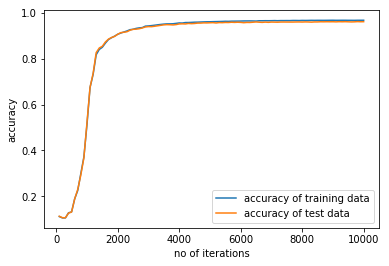

In [36]:
plt.plot(np.arange(100,10001,100),pred_train,label='accuracy of training data')
plt.plot(np.arange(100,10001,100),pred_valid,label='accuracy of test data')
plt.xlabel('no of iterations')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('train_validation_H3.png')
plt.show()


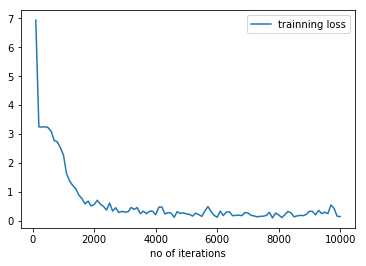

In [37]:
plt.plot(np.arange(100,10001,100),costs,label='trainning loss')
plt.xlabel('no of iterations')
plt.legend()
plt.savefig('train_loss.png')
plt.show()


In [38]:
print('Training accuracy:',pred_train[-1]*100)
print('Test accuracy:',pred_valid[-1]*100)

Training accuracy: 96.72545454545455
Test accuracy: 96.1
